In [29]:
!pip install pyspark

In [30]:

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BigDataPrj") \
    .getOrCreate()

print("Apache Spark Session successfully created!")

Apache Spark Session successfully created!


In [31]:
# 1. Download the file from a public source into the Colab environment
# This is a common practice to get data quickly into a hosted notebook.
!wget -q https://raw.githubusercontent.com/databricks/Spark-The-Definitive-Guide/master/data/retail-data/by-day/2010-12-01.csv

# 2. Define the file path
file_path = "2010-12-01.csv"

# 3. Read the CSV file into a Spark DataFrame
# header=True: Use the first row for column names (e.g., InvoiceNo, Quantity)
# inferSchema=True: Spark guesses the data type for each column (e.g., Integer, String)
df = spark.read.csv(file_path, header=True, inferSchema=True)

print("--- Data Read Successfully ---")

# Show the first 5 rows to verify the load
df.show(5)

# Print the schema to check the column names and inferred types
df.printSchema()

--- Data Read Successfully ---
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+-------------

In [32]:
from pyspark.sql.functions import col, lit, count, when, isnull

# Rename columns to remove spaces and standardize case
df_clean = df.withColumnRenamed("InvoiceNo", "InvoiceNumber") \
             .withColumnRenamed("StockCode", "StockCode") \
             .withColumnRenamed("CustomerID", "CustomerID") \
             .withColumnRenamed("InvoiceDate", "InvoiceDate") \
             .withColumnRenamed("UnitPrice", "UnitPrice") \
             .withColumnRenamed("Country", "Country")

print("--- Schema After Renaming ---")
df_clean.printSchema()

--- Schema After Renaming ---
root
 |-- InvoiceNumber: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)



In [33]:
print("--- Missing Value Check (Before Cleaning) ---")

# Calculate the count of nulls for each column
df_clean.select([count(when(isnull(c), c)).alias(c) for c in df_clean.columns]).show()

# 1. DROP rows where CustomerID is null
df_cleaned = df_clean.filter(col("CustomerID").isNotNull())

# 2. FILTER out rows where Quantity or UnitPrice is zero or negative
df_cleaned = df_cleaned.filter((col("Quantity") > 0) & (col("UnitPrice") > 0))

print(f"Original Row Count: {df.count()}")
print(f"Cleaned Row Count (after filtering): {df_cleaned.count()}")

--- Missing Value Check (Before Cleaning) ---
+-------------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNumber|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+-------------+---------+-----------+--------+-----------+---------+----------+-------+
|            0|        0|         10|       0|          0|        0|      1140|      0|
+-------------+---------+-----------+--------+-----------+---------+----------+-------+

Original Row Count: 3108
Cleaned Row Count (after filtering): 1942


In [34]:
# Add a new column called 'Sales' (or 'Revenue') by multiplying Quantity and UnitPrice
df_cleaned = df_cleaned.withColumn("Sales", col("Quantity") * col("UnitPrice"))

print("--- Data After Sales Calculation ---")
df_cleaned.show(5)

# Check the schema again to confirm the new 'Sales' column is present
df_cleaned.printSchema()

--- Data After Sales Calculation ---
+-------------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|InvoiceNumber|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|             Sales|
+-------------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+
|       536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|15.299999999999999|
|       536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|             20.34|
|       536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|              22.0|
|       536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|             20.34|
|       536365|   84029E|RED WOOLLY HOTTIE...|

In [35]:
from pyspark.sql.functions import sum, desc, count

print("--- Analysis 1: Key Metrics ---")

# 1. Calculate the Overall Total Sales
# .agg(): performs an aggregation; .collect()[0][...]: extracts the single result value
total_sales_result = df_cleaned.agg(sum("Sales").alias("TotalSales")).collect()[0]["TotalSales"]
print(f"\nOverall Total Sales (for this day): ${total_sales_result:,.2f}")

# 2. Find the Top 10 Selling Products by revenue
top_products = df_cleaned.groupBy("Description") \
    .agg(sum("Sales").alias("ProductSales")) \
    .orderBy(desc("ProductSales")) \
    .limit(10)

print("\nTop 10 Products by Sales:")
top_products.show(truncate=False)

--- Analysis 1: Key Metrics ---

Overall Total Sales (for this day): $46,376.49

Top 10 Products by Sales:
+----------------------------------+------------------+
|Description                       |ProductSales      |
+----------------------------------+------------------+
|BLACK RECORD COVER FRAME          |1830.6000000000001|
|RED WOOLLY HOTTIE WHITE HEART.    |1655.3100000000002|
|WHITE HANGING HEART T-LIGHT HOLDER|1147.35           |
|CHILLI LIGHTS                     |1079.04           |
|JUMBO BAG RED RETROSPOT           |930.3             |
|SET OF 3 COLOURED  FLYING DUCKS   |813.9000000000001 |
|FAIRY TALE COTTAGE NIGHTLIGHT     |684.9             |
|LIGHT GARLAND BUTTERFILES PINK    |681.04            |
|WOODEN OWLS LIGHT GARLAND         |681.04            |
|STRAWBERRY CERAMIC TRINKET BOX    |633.96            |
+----------------------------------+------------------+



In [36]:
print("--- Analysis 2: Customer and Geography ---")

# 1. Top 5 Customers by Revenue (for Customer Segmentation insight)
top_customers = df_cleaned.groupBy("CustomerID") \
    .agg(sum("Sales").alias("CustomerTotalSpend")) \
    .orderBy(desc("CustomerTotalSpend")) \
    .limit(5)

print("\nTop 5 Customers by Total Spend:")
top_customers.show()

# 2. Sales by Country (for Visualization insight)
sales_by_country = df_cleaned.groupBy("Country") \
    .agg(sum("Sales").alias("TotalSales")) \
    .orderBy(desc("TotalSales"))

print("\nTop 10 Countries by Sales:")
sales_by_country.show(10, truncate=False)

--- Analysis 2: Customer and Geography ---

Top 5 Customers by Total Spend:
+----------+------------------+
|CustomerID|CustomerTotalSpend|
+----------+------------------+
|   13777.0|           6585.16|
|   16029.0|           3702.12|
|   16210.0|2474.7399999999993|
|   12433.0|1919.1400000000008|
|   17511.0|           1825.74|
+----------+------------------+


Top 10 Countries by Sales:
+--------------+------------------+
|Country       |TotalSales        |
+--------------+------------------+
|United Kingdom|42233.78000000018 |
|Norway        |1919.1400000000008|
|France        |855.86            |
|EIRE          |555.3799999999999 |
|Australia     |358.25            |
|Germany       |261.48            |
|Netherlands   |192.60000000000002|
+--------------+------------------+



In [37]:
import plotly.io as pio

# Set the default renderer to 'colab' to ensure compatibility
pio.renderers.default = 'colab'

--- Alternative Visualization: Top 10 Products Chart (Seaborn) ---


/tmp/ipython-input-606198611.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




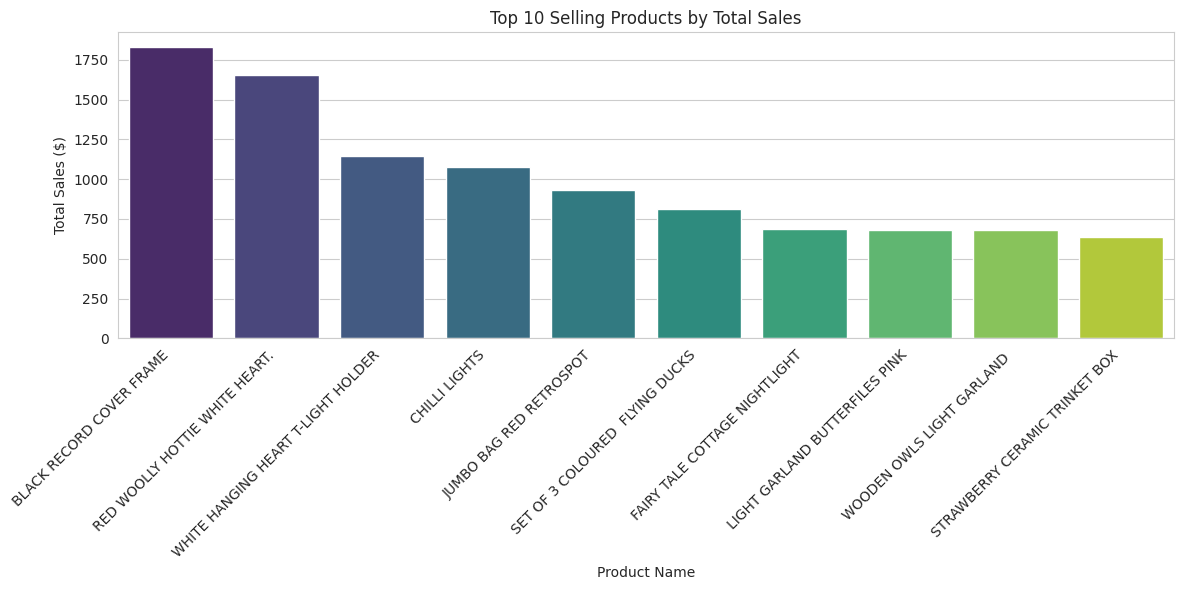

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Alternative Visualization: Top 10 Products Chart (Seaborn) ---")

# Set a style for better presentation
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Create the bar chart using Seaborn
sns.barplot(
    x='Description',
    y='ProductSales',
    data=top_products_pd, # Uses the Pandas DataFrame you already created
    palette="viridis"
)

plt.title('Top 10 Selling Products by Total Sales')
plt.xlabel('Product Name')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.tight_layout()

# 🔥 THE FIX: plt.show() is the standard way to display Matplotlib charts.
plt.show()


--- Dashboard Chart 2: Sales by Country (Top 10) ---


/tmp/ipython-input-1028398142.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




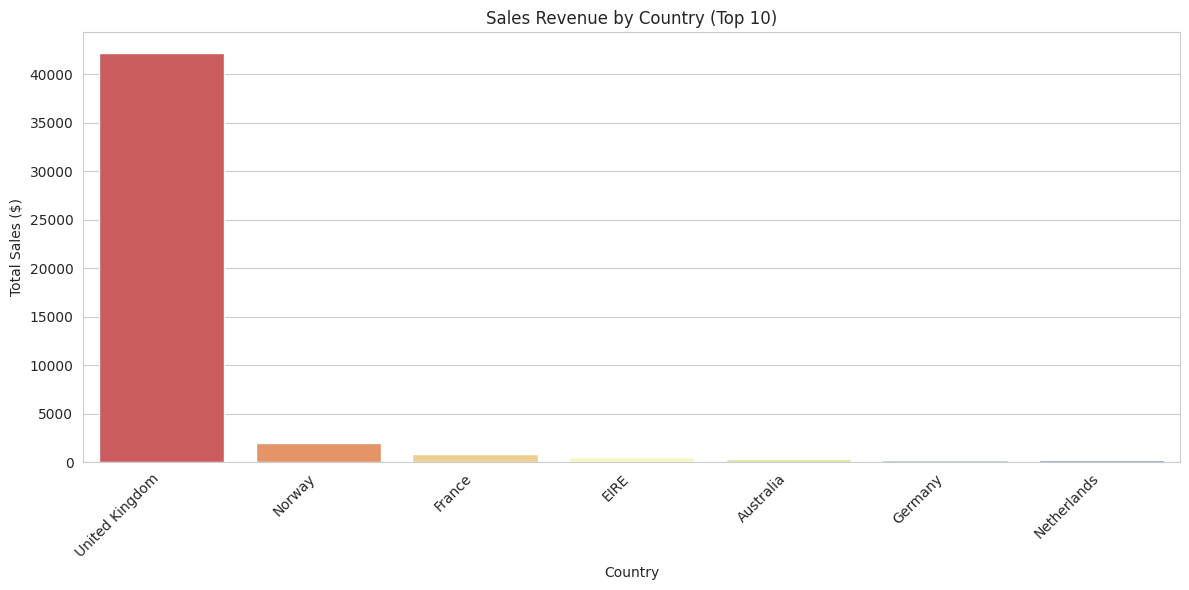

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume sales_by_country_pd is defined from the PySpark conversion

print("\n--- Dashboard Chart 2: Sales by Country (Top 10) ---")

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Create the bar chart using Seaborn
sns.barplot(
    x='Country',
    y='TotalSales',
    data=sales_by_country_pd, # Uses the Pandas DataFrame you already created
    palette="Spectral"
)

plt.title('Sales Revenue by Country (Top 10)')
plt.xlabel('Country')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.tight_layout()

# This method guarantees display in Colab
plt.show()

In [40]:
from pyspark.sql.functions import sum, countDistinct, col

# Check if total_sales_result is defined, if not, calculate it (for safety)
try:
    if 'total_sales_result' not in locals():
        total_sales_result = df_cleaned.agg(sum("Sales").alias("TotalSales")).collect()[0]["TotalSales"]
except:
    print("Warning: Could not find total_sales_result. Ensure df_cleaned is loaded.")

print("--- DASHBOARD KEY METRICS ---")

# A. Calculate the Overall Total Sales
# This is a key metric card on the dashboard [cite: 20]
print(f"1. Overall Total Sales: ${total_sales_result:,.2f}")

# B. Calculate the Total Number of Unique Customers
# This is another crucial aggregation [cite: 20]
total_customers = df_cleaned.select(countDistinct(col("CustomerID"))).collect()[0][0]
print(f"2. Total Unique Customers: {total_customers:,}")

# C. Top Selling Country (using the result from your Country chart analysis)
# This is derived from the chart but often presented as a key metric card.
top_country = sales_by_country.limit(1).collect()[0]["Country"]
print(f"3. Top Selling Country: {top_country}")

--- DASHBOARD KEY METRICS ---
1. Overall Total Sales: $46,376.49
2. Total Unique Customers: 95
3. Top Selling Country: United Kingdom


In [41]:
from pyspark.sql.functions import sum, countDistinct, col

print("\n--- FILTER DEMO 1: COUNTRY SELECTOR (Drill Down) ---")

# Define the country the user has 'selected'
selected_country = "Norway"

# Filter the DataFrame for the selected country
filtered_data = df_cleaned.filter(col("Country") == selected_country)

# Run aggregations on the filtered data
filtered_summary = filtered_data.agg(
    sum("Sales").alias("Filtered_TotalSales"),
    countDistinct("CustomerID").alias("Filtered_TotalCustomers")
).collect()[0]

print(f"\nResults Filtered by Country: {selected_country}")
print(f"   Total Sales: ${filtered_summary['Filtered_TotalSales']:,.2f}")
print(f"   Total Customers: {filtered_summary['Filtered_TotalCustomers']:,}")


--- FILTER DEMO 1: COUNTRY SELECTOR (Drill Down) ---

Results Filtered by Country: Norway
   Total Sales: $1,919.14
   Total Customers: 1


In [42]:
from pyspark.sql.functions import sum, date_format
import plotly.express as px # Re-import if you want to use the line chart
import pandas as pd

print("\n--- FILTER DEMO 2: DATE/TIME FILTER (Hourly Trend) ---")

# Add a column for the hour of the day
df_hourly_sales = df_cleaned.withColumn(
    "InvoiceHour",
    date_format(col("InvoiceDate"), "HH") # Extract hour in 24h format (00-23)
)

# Group by hour and aggregate sales
hourly_trend = df_hourly_sales.groupBy("InvoiceHour") \
    .agg(sum("Sales").alias("HourlySales")) \
    .orderBy("InvoiceHour")

print("Hourly Sales Trend (First 5 hours of operation):")
hourly_trend.show(5)

# Convert and plot the trend (This is often a key chart enabled by the Date/Time filter)
hourly_trend_pd = hourly_trend.toPandas()

fig_hourly = px.line(
    hourly_trend_pd,
    x='InvoiceHour',
    y='HourlySales',
    title='Sales Trend by Hour of Day',
    labels={'InvoiceHour': 'Hour of Day (24h)', 'HourlySales': 'Total Sales ($)'}
)
fig_hourly.show()


--- FILTER DEMO 2: DATE/TIME FILTER (Hourly Trend) ---
Hourly Sales Trend (First 5 hours of operation):
+-----------+------------------+
|InvoiceHour|       HourlySales|
+-----------+------------------+
|         08|1383.8099999999997|
|         09|7356.3899999999985|
|         10| 5235.809999999998|
|         11|4234.1599999999935|
|         12| 7447.919999999994|
+-----------+------------------+
only showing top 5 rows

